In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
df_clean_path = r"D:\UNH Materials\Projects\Spotify Song Recommendations\data\df_clean.csv"

# Step 1: Create a copy of df_clean for classification
df_clean = pd.read_csv(df_clean_path)
print(f"\n1. Created ml_class_df with shape: {df_clean.shape}")


1. Created ml_class_df with shape: (85000, 32)


In [7]:
df_clean.columns

Index(['track_id', 'track_name', 'artist_name', 'album_name', 'release_date',
       'genre', 'duration_ms', 'popularity', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'instrumentalness', 'tempo', 'stream_count',
       'country', 'explicit', 'label', 'release_year', 'release_month',
       'release_quarter', 'release_week', 'release_day_of_week',
       'duration_min', 'popularity_bin', 'stream_category', 'key_label',
       'energy_danceability', 'popularity_energy', 'instrumentalness_energy',
       'mode_label'],
      dtype='object')

In [34]:
# 1. Separate Features and Target
X = df_clean.drop(['genre', 'track_id', 'track_name', 'artist_name', 'album_name', 'release_date'], axis=1)
y = df_clean['genre']

cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['number']).columns

# 2. Encode Labels
x_le_dict = {}
X_cat = X[cat_cols].copy()
for col in cat_cols:
    le = LabelEncoder()
    X_cat[col] = le.fit_transform(X_cat[col])
    x_le_dict[col] = le

X_num = X[num_cols].copy()

# 3. Stratified Split on whole data, so we can scale train/test splits only
X_all_encoded = pd.concat([X_num, X_cat], axis=1)  # For train_test_split, use all columns but separately prepared
y_le = LabelEncoder()
y_encoded = y_le.fit_transform(y)
class_names = y_le.classes_

X_train, X_test, y_train, y_test = train_test_split(
    X_all_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 4. Scale ONLY the numeric feature columns, then combine with encoded categoricals
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[num_cols])
X_test_num_scaled = scaler.transform(X_test[num_cols])

# Convert scaled arrays back to DataFrames
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=num_cols, index=X_train.index)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=num_cols, index=X_test.index)

# Concatenate scaled numeric with unscaled categorical (already encoded)
X_train_scaled = pd.concat([X_train_num_scaled_df, X_train[cat_cols]], axis=1)
X_test_scaled = pd.concat([X_test_num_scaled_df, X_test[cat_cols]], axis=1)

print(f"Input Features: {X.shape[1]}")
print(f"Classes: {len(class_names)}")

Input Features: 26
Classes: 12


In [39]:
# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    objective='multi:softprob',
    num_class=len(class_names),
    tree_method='hist', # Faster for large datasets
    device='cuda' if torch.cuda.is_available() else 'cpu',
    random_state=42
)

# Train with early stopping to prevent overfitting
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

xgb_preds = xgb_model.predict(X_test)

[0]	validation_0-mlogloss:2.48490
[100]	validation_0-mlogloss:2.55745
[200]	validation_0-mlogloss:2.59893
[300]	validation_0-mlogloss:2.60612
[400]	validation_0-mlogloss:2.62378
[500]	validation_0-mlogloss:2.69636
[600]	validation_0-mlogloss:2.71567
[700]	validation_0-mlogloss:2.71706
[800]	validation_0-mlogloss:2.73181
[900]	validation_0-mlogloss:2.74802
[999]	validation_0-mlogloss:2.78448


In [42]:
class MusicDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoaders
train_ds = MusicDataset(X_train_scaled, y_train)
test_ds = MusicDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

In [47]:
class GenreNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GenreNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
        
    def forward(self, x):
        return self.network(x)

model = GenreNet(X.shape[1], len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Simple Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 5/10, Loss: 2.4842
Epoch 10/10, Loss: 2.4788



--- XGBoost Evaluation ---
Accuracy: 0.0819
              precision    recall  f1-score   support

   Classical       0.08      0.06      0.07      1432
     Country       0.07      0.02      0.03      1406
         EDM       0.08      0.59      0.14      1379
        Folk       0.00      0.00      0.00      1416
     Hip-Hop       0.08      0.16      0.11      1432
       Indie       0.09      0.05      0.06      1401
        Jazz       0.09      0.02      0.03      1435
       Metal       0.06      0.01      0.01      1440
         Pop       0.08      0.04      0.06      1419
         R&B       0.08      0.02      0.03      1417
   Reggaeton       0.00      0.00      0.00      1400
        Rock       0.08      0.02      0.04      1423

    accuracy                           0.08     17000
   macro avg       0.07      0.08      0.05     17000
weighted avg       0.07      0.08      0.05     17000



c:\Users\Sahil\anaconda3\envs\textS\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sahil\anaconda3\envs\textS\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sahil\anaconda3\envs\textS\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


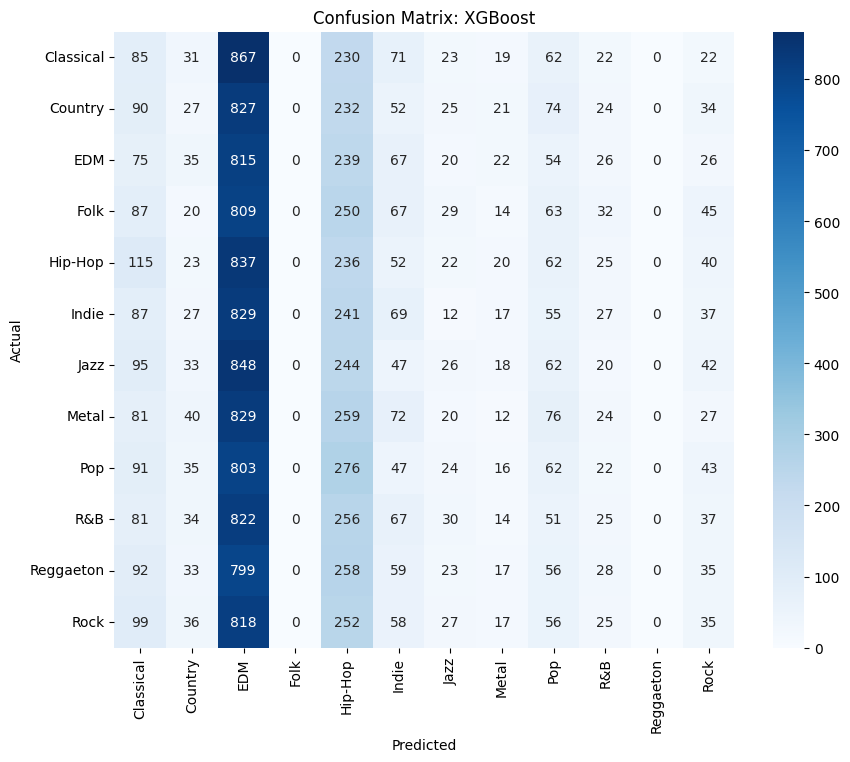


--- Neural Network Evaluation ---
Accuracy: 0.0864
              precision    recall  f1-score   support

   Classical       0.09      0.29      0.13      1432
     Country       0.07      0.02      0.03      1406
         EDM       0.11      0.02      0.04      1379
        Folk       0.09      0.06      0.07      1416
     Hip-Hop       0.09      0.10      0.09      1432
       Indie       0.07      0.01      0.02      1401
        Jazz       0.09      0.12      0.10      1435
       Metal       0.09      0.11      0.10      1440
         Pop       0.09      0.08      0.08      1419
         R&B       0.09      0.07      0.08      1417
   Reggaeton       0.08      0.04      0.06      1400
        Rock       0.08      0.09      0.09      1423

    accuracy                           0.09     17000
   macro avg       0.09      0.09      0.07     17000
weighted avg       0.09      0.09      0.08     17000



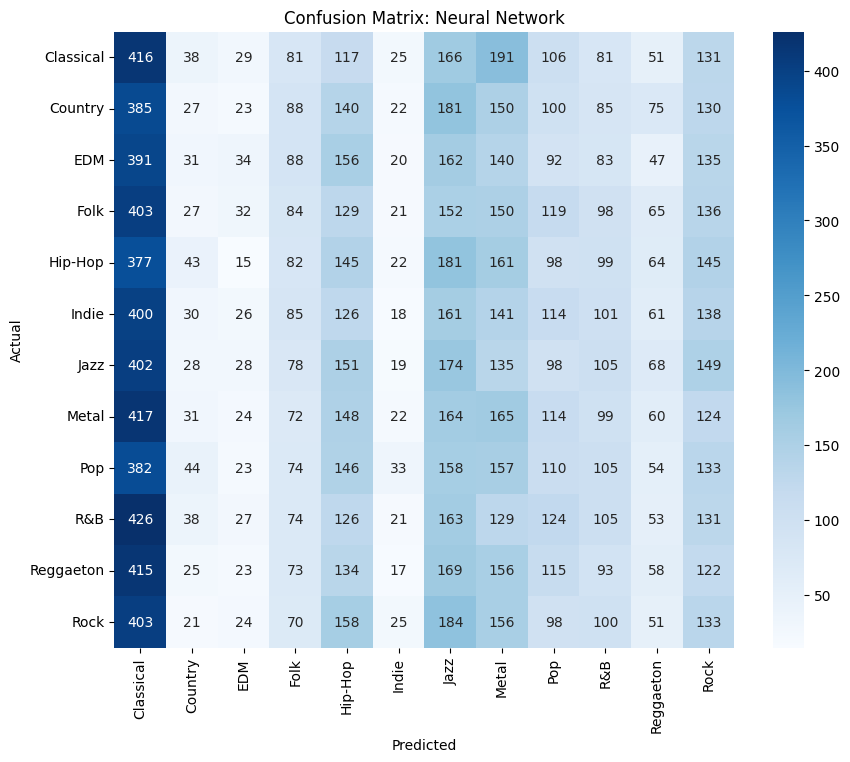

In [49]:
def evaluate_model(y_true, y_pred, model_name, target_names):
    print(f"\n--- {model_name} Evaluation ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Get PyTorch Predictions
model.eval()
nn_preds = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs.to(device))
        _, predicted = torch.max(outputs, 1)
        nn_preds.extend(predicted.cpu().numpy())

# Final Comparison
evaluate_model(y_test, xgb_preds, "XGBoost", class_names)
evaluate_model(y_test, nn_preds, "Neural Network", class_names)